# 0. Intro
1. 计算得到理论模型下对于target data的NLL值作为metric，方便对比


# 1. Preparations
## 1.1 global settings

In [129]:
import pandas as pd
import numpy as np
import math
import random
import os
from operator import itemgetter
from matplotlib import pyplot as plt


# For GT-2
from GT_model.GT_2.SA_for_PT_funcs_delta_eq1 import *
from tqdm import  tqdm

## 1.2 the data path


In [136]:
# Target data
target_path = r"../data/targets"
# target_path = r"../data/targets_5"
# target_path = r"../data/targets_5_cdf"

# target data是target_5时 TARGET = 5
TARGET = 1

# For GT-2
alpha = -0.013581112
delta = 1
labda = 3.312402533

MIN_LOSS = 1e-12

# data keys
data_key_path = "../data/target_datakey.csv"
# inferred params for GT-2 model
#params_opitim_path = "../data/SA_PT/params_opitim_oneforall.csv"


# NLL output path
# NLL_metric_path = "../data/NLL_metric_GT_MIN_LOSS.csv"
NLL_metric_path  ="../data/NLL_metric_GT_Tgt=1_e12.csv"

## 1.3 Read in

In [137]:
settings = pd.read_csv(data_key_path,encoding="utf-8")
#params_all = pd.read_csv(params_opitim_path,encoding="utf-8")
# target_path里有全部的target data地址
target_all_path = os.listdir(target_path)

# 2. 两个GT模型
## 2.1 GT-1

In [138]:
def GT_1(setting, target):
        b = np.array(setting.bidfee)               # bid fee (dollar)
        v = np.array(setting.retail)               # valuation
        d = np.array(setting.bidincrement)

        T = int((v-b)/d)                           # duration limitation

        # Solve for U
        U = [0] * (T + 1)                          # the prob. that someone offers a bid in t_th round
        U[0] = 1
        for t in range(1,len(U)):
                U[t] = 1.0-b/(v-d*(t-1))

        # Solve for P
        p = np.array([0.0]*(T))
        tmp = np.array([0.0]*(T+3))                         # tmp的大小不需要太精确
        tmp[0] = 1.0
        # p[t]表示auction进行(t+1)轮然后结束的概率
        for t in range(0,T):
                tmp[t+1] = tmp[t]*U[t]                      # tmp[t+1]存了到(t)的U的连乘积
                p[t] = (1-U[t+1])*tmp[t+1]
        # To make sure sum=1
        p[T-1] = max(1-sum(p[0:T-1]),0)

        # According to the target data, compute the NLL value

        p_dict = {}
        nll = 0
        i = 0
        # Sum prob in every interval of TARGET
        for i in range(0,len(p),TARGET):
                j = min(len(p),i+TARGET)
                p_dict[i+1] = np.sum(p[i:j])
        # nll = np.sum(itemgetter(*target)(p_dict))
        # Sum up all prob if GT gives one
        for i in range(0, len(target)):
                if target[i] in p_dict:
                        nll += -np.log(p_dict[target[i]]+MIN_LOSS)
                else:
                        nll += -np.log(0.+MIN_LOSS)
        return nll/len(target)

## 2.2 GT-2

In [139]:
def GT_2(setting, target):
        b = np.array(setting.bidfee)               # bid fee (dollar)
        v = np.array(setting.retail)               # valuation
        d = np.array(setting.bidincrement)

        T = int((v-b)/d)                           # duration limitation

        # Solve for U
        U = [0] * (T + 1)                               # the prob. that someone offers a bid in t_th round
        U[0] = 1
        for t in range(1,T+1):
                U[t] = f_Equi(t, v, d, b, alpha, labda)

        # Solve for P
        p = np.array([0.0]*(T))
        tmp = np.array([0.0]*(T+3))                         # tmp的大小不需要太精确
        tmp[0] = 1.0
        # p[t]表示auction进行(t+1)轮然后结束的概率
        for t in range(0,T):
                tmp[t+1] = tmp[t]*U[t]                      # tmp[t+1]存了到(t)的U的连乘积
                p[t] = (1-U[t+1])*tmp[t+1]
        # To make sure sum=1
        p[T-1] = max(1-sum(p[0:T-1]),0)

        # According to the target data, compute the NLL value

        p_dict = {}
        nll = 0
        i = 0
        # Sum prob in every interval of TARGET
        for i in range(0,len(p),TARGET):
                j = min(len(p),i+TARGET)
                p_dict[i+1] = np.sum(p[i:j])
        # nll = np.sum(itemgetter(*target)(p_dict))
        # Sum up all prob if GT gives one
        for i in range(0, len(target)):
                if target[i] in p_dict:
                        nll += -np.log(p_dict[target[i]]+MIN_LOSS)
                else:
                        nll += -np.log(0.+MIN_LOSS)

        return nll/len(target)

# 3. Compute the NLL

In [140]:
NLL_metric = np.array([0]*len(target_all_path)*2).reshape(-1,2)
NLL_metric_pd = pd.DataFrame(NLL_metric,columns=['nll1','nll2'])

for i in tqdm(range(len(target_all_path))):
# for i in range(1):
        # Get target data
        target_path_i_path = os.path.join(target_path, target_all_path[i])
        target_df = pd.read_csv(target_path_i_path,encoding="utf-8")
        target = list(target_df.iloc[:,0])

        # Get the auction setting
        settings_df = settings.iloc[i,:]

        # Compute the NLL value of each GT models
        NLL_metric_pd.iloc[i,0] = GT_1(settings_df,target)
        NLL_metric_pd.iloc[i,1] = GT_2(settings_df,target)

100%|██████████| 1196/1196 [04:13<00:00,  4.72it/s]


# 4. Output

In [141]:
NLL_metric_pd.to_csv(NLL_metric_path,encoding="utf-8",header=True,index=False)

# 5. test
## 5.1 MINloss test
1. 读取不同MINLoss下的metric，看一下MINLoss对于结果有无影响
2. plot: 横轴MINLoss，纵轴metric

In [142]:
metric_list = [2,4,6,8,10,12,20]

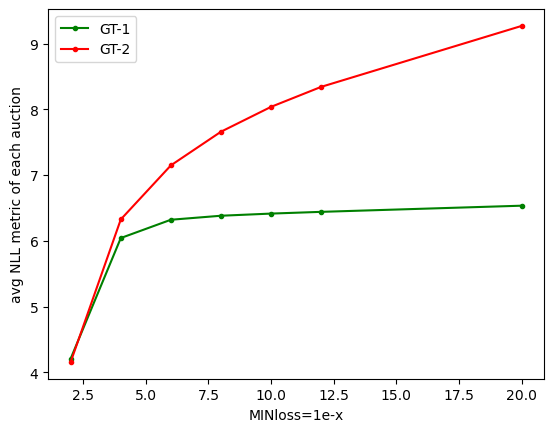

In [182]:
metric = np.array([0]*len(metric_list)*2).reshape(-1,2)
metric_pd = pd.DataFrame(metric)

for i in range(len(metric_list)):
        file_head = "../data/NLL_metric_GT_Tgt=1_e"
        file_end = ".csv"

        file_name = file_head + str(metric_list[i]) + file_end

        data = pd.read_csv(file_name,encoding="utf-8")
        metric_i = np.array(data.sum(axis=0))

        metric_pd.iloc[i,0] = metric_i[0]
        metric_pd.iloc[i,1] = metric_i[1]


metric_pd = metric_pd/ len(target_all_path)
plt.plot(metric_list, metric_pd.iloc[:,0], color='green', marker = ".", label='GT-1')
plt.plot(metric_list, metric_pd.iloc[:,1], color='red', marker = ".", label='GT-2')

plt.xlabel('MINloss=1e-x')
plt.ylabel('avg NLL metric of each auction')
plt.legend()
plt.show()